# If you want to access the version you have already modified, click "Edit"
# If you want to access the original sample code, click "...", then click "Copy & Edit Notebook"

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.0.1+cu117
True


In [2]:
import cv2

In [3]:
torch.cuda.set_device(3)

In [4]:
_exp_name = "pre_semi_spin"
number_class=101
test_name='mean10_MAD_spin'
a_type_1='10_a+0.94'
a_type_2='10_a+0.5'
a_type_3='10_a0'

In [5]:
# Import necessary packages.
import numpy as np
import os
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset

# This is for the progress bar.
from tqdm.auto import tqdm
import random

In [6]:
myseed = 1019  # set a random seed for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(myseed)
torch.manual_seed(myseed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(myseed)

## **Transforms**
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Please refer to PyTorch official website for details about different transforms.

In [7]:
# Normally, We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# However, it is also possible to use augmentation in the testing phase.
# You may use train_tfm to produce a variety of images and then test using ensemble methods
train_tfm = transforms.Compose([
    # Resize the image into a fixed shape (height = width = 128)
    transforms.Resize((224, 224)),
    # You may add some transforms here.
    # ToTensor() should be the last one of the transforms.
    transforms.ToTensor(),
])


## **Datasets**
The data is labelled by the name, so we load images and label while calling '__getitem__'

In [8]:
#只有100張疊1張適用

'''
import os
import cv2
import numpy as np

def RHdataset(root_dir,label_num,num_samples=None):
    if num_samples is None:
        num_samples = 100 
    Rh_data = []
    IMG_SIZE = 224
    
    img_list = [img_name for img_name in os.listdir(root_dir) if not img_name.startswith('.')]
    selected_imgs = random.sample(img_list, min(num_samples, len(img_list)))
    for img_name in selected_imgs:
        img_path = os.path.join(root_dir, img_name)
        kk = cv2.imread(img_path)  # 從path加入照片
        if kk is not None:
            new_array = cv2.resize(kk, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_LINEAR)           
            Rh_data.append(new_array)
        else:
            print(f"無法讀取圖像: {img_path}")
    
    avg_data=np.mean(Rh_data,axis=0)
    
    Rh_label = np.ones(1, dtype=int) * label_num
    
    return avg_data, Rh_label
'''


'\nimport os\nimport cv2\nimport numpy as np\n\ndef RHdataset(root_dir,label_num,num_samples=None):\n    if num_samples is None:\n        num_samples = 100 \n    Rh_data = []\n    IMG_SIZE = 224\n    \n    img_list = [img_name for img_name in os.listdir(root_dir) if not img_name.startswith(\'.\')]\n    selected_imgs = random.sample(img_list, min(num_samples, len(img_list)))\n    for img_name in selected_imgs:\n        img_path = os.path.join(root_dir, img_name)\n        kk = cv2.imread(img_path)  # 從path加入照片\n        if kk is not None:\n            new_array = cv2.resize(kk, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_LINEAR)           \n            Rh_data.append(new_array)\n        else:\n            print(f"無法讀取圖像: {img_path}")\n    \n    avg_data=np.mean(Rh_data,axis=0)\n    \n    Rh_label = np.ones(1, dtype=int) * label_num\n    \n    return avg_data, Rh_label\n'

In [9]:
import os
import cv2
import numpy as np

def RHdataset(root_dir,label_num,num_samples=None):
    if num_samples is None:
        num_samples = 100 
    Rh_data = []
    IMG_SIZE = 224
    
    img_list = [img_name for img_name in os.listdir(root_dir) if not img_name.startswith('.')]
    selected_imgs = random.sample(img_list, min(num_samples, len(img_list)))
    for img_name in selected_imgs:
        img_path = os.path.join(root_dir, img_name)
        kk = cv2.imread(img_path)  # 從path加入照片
        if kk is not None:
            new_array = cv2.resize(kk, (IMG_SIZE, IMG_SIZE),interpolation=cv2.INTER_LINEAR)           
            Rh_data.append(new_array)
        else:
            print(f"無法讀取圖像: {img_path}")

    Rh_label = np.ones(len(Rh_data), dtype=int) * label_num
    
    return Rh_data, Rh_label

In [10]:
u94_Rh1_data,u94_Rh1_label = RHdataset(root_dir=f"mean_MAD/{a_type_1}/Rh1",label_num=94)
u94_Rh160_data,u94_Rh160_label=RHdataset(root_dir=f"mean_MAD/{a_type_1}/Rh160",label_num=94)

In [11]:
u94_Rh10_data,u94_Rh10_label=RHdataset(root_dir=f"mean_MAD/{a_type_1}/Rh10",label_num=94)
u94_Rh20_data,u94_Rh20_label=RHdataset(root_dir=f"mean_MAD/{a_type_1}/Rh20",label_num=94)

In [12]:
u94_Rh40_data,u94_Rh40_label=RHdataset(root_dir=f"mean_MAD/{a_type_1}/Rh40",label_num=94)
u94_Rh80_data,u94_Rh80_label=RHdataset(root_dir=f"mean_MAD/{a_type_1}/Rh80",label_num=94)

In [13]:
n94_Rh1_data,n94_Rh1_label = RHdataset(root_dir=f"mean_MAD/{a_type_3}/Rh1",label_num=0)
n94_Rh160_data,n94_Rh160_label=RHdataset(root_dir=f"mean_MAD/{a_type_3}/Rh160",label_num=0)

In [14]:
n94_Rh10_data,n94_Rh10_label = RHdataset(root_dir=f"mean_MAD/{a_type_3}/Rh10",label_num=0)
n94_Rh20_data,n94_Rh20_label=RHdataset(root_dir=f"mean_MAD/{a_type_3}/Rh20",label_num=0)

In [15]:
n94_Rh40_data,n94_Rh40_label = RHdataset(root_dir=f"mean_MAD/{a_type_3}/Rh40",label_num=0)
n94_Rh80_data,n94_Rh80_label=RHdataset(root_dir=f"mean_MAD/{a_type_3}/Rh80",label_num=0)

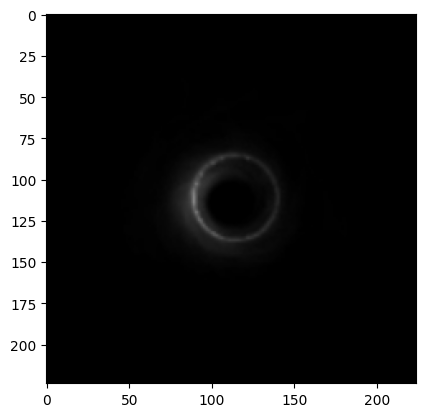

In [16]:
import matplotlib.pyplot as plt
u94_Rh1_data = np.clip(u94_Rh1_data, 0, 255).astype(np.uint8)

plt.imshow(u94_Rh1_data[0])
plt.show()

In [17]:

d94_Rh1_data,d94_Rh1_label = RHdataset(root_dir=f"mean_MAD/{a_type_2}/Rh1",label_num=50)
d94_Rh10_data,d94_Rh10_label=RHdataset(root_dir=f"mean_MAD/{a_type_2}/Rh10",label_num=50)


In [18]:

d94_Rh20_data,d94_Rh20_label=RHdataset(root_dir=f"mean_MAD/{a_type_2}/Rh20",label_num=50)
d94_Rh40_data,d94_Rh40_label=RHdataset(root_dir=f"mean_MAD/{a_type_2}/Rh40",label_num=50)


In [19]:

d94_Rh80_data,d94_Rh80_label=RHdataset(root_dir=f"mean_MAD/{a_type_2}/Rh80",label_num=50)
d94_Rh160_data,d94_Rh160_label=RHdataset(root_dir=f"mean_MAD/{a_type_2}/Rh160",label_num=50)


In [20]:
print(len(u94_Rh1_label))

10


In [21]:
# torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
# torch.nn.MaxPool2d(kernel_size, stride, padding)
# input 維度 [128,128,3]

In [22]:
import torchvision.models as models
# 載入預先訓練的 ResNet-18 模型
device = "cuda" if torch.cuda.is_available() else "cpu"  # "cuda" only when GPUs are available.
model = models.resnet18(pretrained=True)

# 將全連接層（分類層）修改為輸出 10 類的層
model.fc = nn.Linear(model.fc.in_features, number_class)

model = model.to(device)
# 定義 MSE loss
criterion = nn.MSELoss()

# 定義優化器
optimizer = torch.optim.Adam(model.parameters(), lr=5e-6,weight_decay=1e-7)

/home/DomCheng/miniconda3/envs/mas/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/DomCheng/miniconda3/envs/mas/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [23]:
from torchsummary import summary
device = "cuda" if torch.cuda.is_available() else "cpu"  # "cuda" only when GPUs are available.
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [24]:
train_data=np.array(u94_Rh1_data)
label=np.array(u94_Rh1_label)
#d94_Rh1_data,d94_Rh10_data,d94_Rh20_data,d94_Rh40_data,d94_Rh80_data,d94_Rh160_data
#d94_Rh1_label,d94_Rh10_label,d94_Rh20_label,d94_Rh40_label,d94_Rh80_label,d94_Rh160_label
data_targets=[u94_Rh10_data,u94_Rh20_data,u94_Rh40_data,u94_Rh80_data,u94_Rh160_data,
             d94_Rh1_data,d94_Rh10_data,d94_Rh20_data,d94_Rh40_data,d94_Rh80_data,d94_Rh160_data,
             n94_Rh1_data,n94_Rh10_data,n94_Rh20_data,n94_Rh40_data,n94_Rh80_data,n94_Rh160_data]

data_labels=[u94_Rh10_label,u94_Rh20_label,u94_Rh40_label,u94_Rh80_label,u94_Rh160_label,
            d94_Rh1_label,d94_Rh10_label,d94_Rh20_label,d94_Rh40_label,d94_Rh80_label,d94_Rh160_label,
            n94_Rh1_label,n94_Rh10_label,n94_Rh20_label,n94_Rh40_label,n94_Rh80_label,n94_Rh160_label]
for i in data_targets:
    gg=np.array(i)
    train_data=np.append(train_data,gg,axis=0)

for i in data_labels:
    jj=np.array(i)
    label=np.append(label,jj)


In [25]:
class RhDataset(Dataset):
    def __init__(self):
        self.x=train_data
        self.y=label

    def __getitem__(self, idx):
        
        return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.y)

In [26]:
batch_size=32
train_set = RhDataset()

In [27]:
'''
train_data_point, label_0 = train_set[101]
print(label_0)
'''

'\ntrain_data_point, label_0 = train_set[101]\nprint(label_0)\n'

In [28]:
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
#valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True,num_workers=0, pin_memory=True)
test_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True,num_workers=0, pin_memory=True)

In [29]:
len(train_set)

180

## Testing and generate prediction CSV

In [30]:
#100疊1張適用

'''
import seaborn as sns
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"  # "cuda" only when GPUs are available.

model = models.resnet18(pretrained=True)

# 將全連接層（分類層）修改為輸出 10 類的層
model.fc = nn.Linear(model.fc.in_features, 101)

model_best = model.to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_{myseed}_best.ckpt"))
model_best.eval()


total_y_true = []
total_predi = []

for p in tqdm(range(len(train_set))):
    
    for batch in test_loader:
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #print(len(labels))
        imgs = imgs.float()
        imgs = torch.unsqueeze(imgs, dim=0)  # 在第0维上增加一个维度
        imgs = imgs.permute(0,3, 2, 1)
        
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            test_pred = model_best(imgs.to(device))
    
    total_predi.append(test_pred.argmax(dim=-1).cpu())
    #print(f'epoch {p} is ok.') 
    p=p+1
    
total_y_true.append(labels.cpu())


#llabels=np.array(['Rh1','Rh10','Rh20','Rh40','Rh80','Rh160'])   
#print(len(np.concatenate(total_y_true)))
#print(len(np.concatenate(total_predi)))
'''

'\nimport seaborn as sns\nimport matplotlib.pyplot as plt\n\ndevice = "cuda" if torch.cuda.is_available() else "cpu"  # "cuda" only when GPUs are available.\n\nmodel = models.resnet18(pretrained=True)\n\n# 將全連接層（分類層）修改為輸出 10 類的層\nmodel.fc = nn.Linear(model.fc.in_features, 101)\n\nmodel_best = model.to(device)\nmodel_best.load_state_dict(torch.load(f"{_exp_name}_{myseed}_best.ckpt"))\nmodel_best.eval()\n\n\ntotal_y_true = []\ntotal_predi = []\n\nfor p in tqdm(range(len(train_set))):\n    \n    for batch in test_loader:\n        # A batch consists of image data and corresponding labels.\n        imgs, labels = batch\n        #print(len(labels))\n        imgs = imgs.float()\n        imgs = torch.unsqueeze(imgs, dim=0)  # 在第0维上增加一个维度\n        imgs = imgs.permute(0,3, 2, 1)\n        \n        # We don\'t need gradient in validation.\n        # Using torch.no_grad() accelerates the forward process.\n        with torch.no_grad():\n            test_pred = model_best(imgs.to(device))\n    \n   

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"  # "cuda" only when GPUs are available.

model = models.resnet18(pretrained=True)

# 將全連接層（分類層）修改為輸出 10 類的層
model.fc = nn.Linear(model.fc.in_features, 101)

model_best = model.to(device)
model_best.load_state_dict(torch.load(f"{_exp_name}_{myseed}_best.ckpt"))
model_best.eval()


total_y_true = []
total_predi = []

for p in tqdm(range(200)):
    
    for batch in test_loader:
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        imgs = imgs.float()
        imgs = imgs.permute(0, 3, 1, 2)
        #imgs = torch.unsqueeze(imgs, dim=0)  # 在第0维上增加一个维度
        
        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
            test_pred = model_best(imgs.to(device))
    total_y_true.append(labels.cpu())
    total_predi.append(test_pred.argmax(dim=-1).cpu())
    #print(f'epoch {p} is ok.') 
    p=p+1


/home/DomCheng/miniconda3/envs/mas/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/DomCheng/miniconda3/envs/mas/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


  0%|          | 0/200 [00:00<?, ?it/s]

In [32]:
print(len(np.concatenate(total_y_true)))

4000


In [33]:
print(len(np.concatenate(total_predi)))

4000


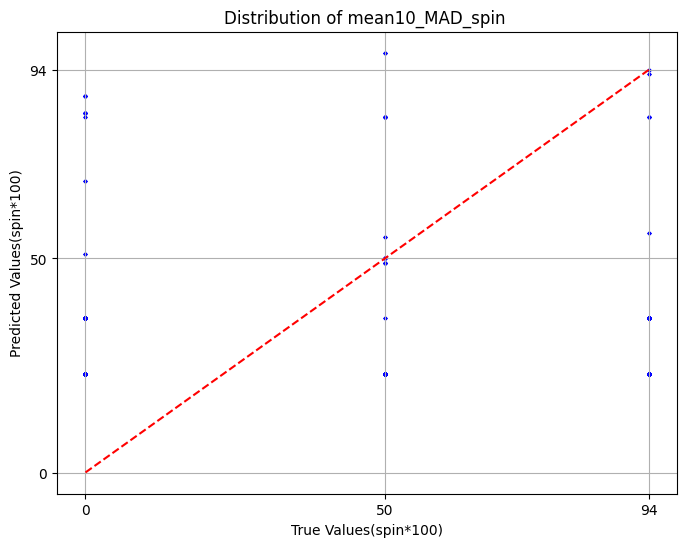

In [34]:
import matplotlib.pyplot as plt


yy_true=np.concatenate(total_y_true)
yy_pre=np.concatenate(total_predi)


plt.figure(figsize=(8, 6))
plt.scatter(yy_true,yy_pre, marker='o', color='blue',s=2, alpha=0.5)
plt.plot([max(yy_true), min(yy_true)], [max(yy_true), min(yy_true)], linestyle='--', color='red')  # 將對角線畫出，作為參考
plt.xlabel('True Values(spin*100)')
plt.ylabel('Predicted Values(spin*100)')
plt.xticks([0, 50, 94])
plt.yticks([0, 50, 94])
plt.title(f'Distribution of {test_name} ')
plt.grid(True)
plt.savefig(f"Distribution_{test_name}_{_exp_name}_{myseed}.png")
plt.show()

In [35]:
cat_total_y_true = torch.cat(total_y_true)

# 將 PyTorch 張量轉換為 NumPy 陣列
cat_total_y_true = cat_total_y_true.numpy()
cat_total_y_true = cat_total_y_true.flatten()

cat_total_y_pre = torch.cat(total_predi)

# 將 PyTorch 張量轉換為 NumPy 陣列
cat_total_y_pre = cat_total_y_pre.numpy()
cat_total_y_pre = cat_total_y_pre.flatten()
#print(cat_total_y_true.flatten())

In [36]:
for i in [0, 50, 94]:
    qq = np.where(np.array(cat_total_y_true) == i)
    if i== 0:
        Rh1 = np.array([tensor.item() for tensor in cat_total_y_pre[qq[0]]])
    if i==50:
        Rh10 = np.array([tensor.item() for tensor in cat_total_y_pre[qq[0]]])
    if i==94:
        Rh20 = np.array([tensor.item() for tensor in cat_total_y_pre[qq[0]]])


In [37]:
#Rh1

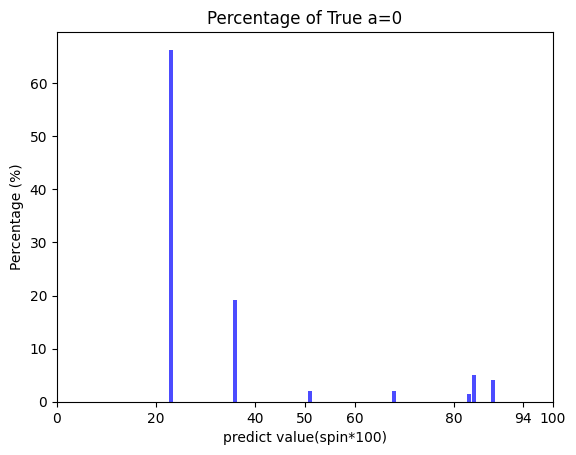

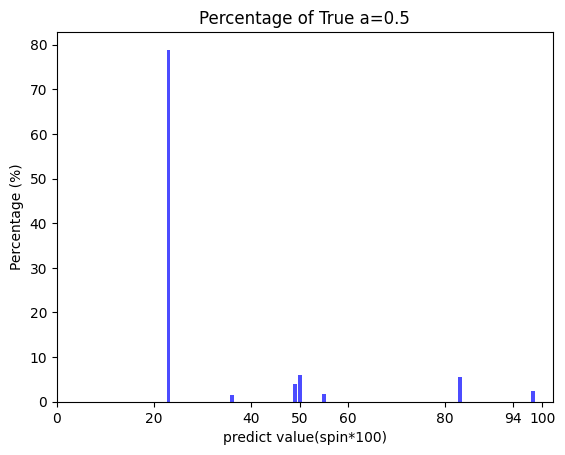

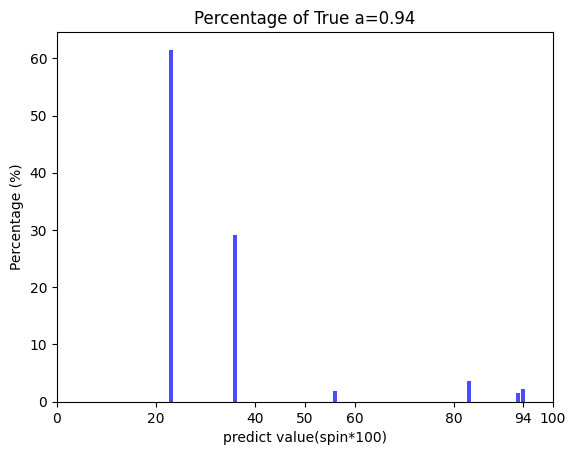

In [38]:
import matplotlib.pyplot as plt
from collections import Counter

# 已知數據
for i,j in zip([Rh1,Rh10,Rh20],[0,0.5,0.94]):
    uu = i

    # 計算每個數字的數量
    counter = Counter(uu)

    # 計算每個數字的百分比
    total_count = len(uu)
    percentage = [count / total_count * 100 for count in counter.values()]

    # 繪製直方圖
    plt.bar(counter.keys(), percentage, color='blue', alpha=0.7)
    plt.xticks([0,20,40,50,60,80,94,100])
    plt.xlabel('predict value(spin*100)')
    plt.ylabel('Percentage (%)')
    plt.title(f'Percentage of True a={j}')
    plt.show()


In [39]:
Rh10

array([50, 23, 23, ..., 23, 23, 50])